Import modules

In [5]:
import torch
import random
import numpy as np
from tqdm import tqdm
from os import makedirs
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torch.nn.functional import sigmoid
#Import local files
from library.dataset import SequenceTyphoonDataset as STD
from library.lstm_predictor import LSTM
from library.dataset import NORMALIZATION

Define necessary paths

In [6]:
_preprocessed_path="C:/Users/nilss/Desktop/Advanded ML FOLDer/outputs-Typhoon_prediction/r34p_10k_w6"
_path_to_dataset='F:/Data folder for ML/AU/AU'
#_path_checkpoint="c:/Users/nilss/Desktop/Advanded ML FOLDer/outputs-Typhoon_prediction/models/ts/lstm_10kp_3l_1024_3i_pressure/checkpoint_3.pth"
_path_checkpoint='C:/Users/nilss/Desktop/Advanded ML FOLDer/models/ts/lstm_1748975535/checkpoint_21006.pth'


In [7]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
labels_ = ["pressure"]

if "grade" in labels_:
    def filter_func(x):
        return x.grade() < 7
elif "pressure" in labels_:
    def filter_func(x):
        return x.grade() < 6

def filter_func(x):
    return x.grade() < 6
# The following code calls STD is hardcoded. If arguments are changed, this needs to be changed
dataset = STD(labels=["month", "day", "hour", "pressure", "wind"],
            preprocessed_path=_preprocessed_path,
            x=[0,1,2,3,4],
            y=[3,4],
            latent_dim=len([int(x) for x in str("3,4").split(",")]),
            num_inputs=3,
            num_preds=8,
            interval=3,
            filter_func=filter_func,
            prefix = _path_to_dataset, # Path
            output_all=True,
            pred_diff=False,
            )
train, val, test = dataset.random_split([0.7, 0.15, 0.15], split_by="sequence")

print(f"\n{len(train)} train sequences")
print(f"{len(val)} val sequences")
print(f"{len(test)} test sequences")

test_loader = DataLoader(test,
                        batch_size=1,
                        shuffle=False,
                        num_workers=0,
                        collate_fn=lambda x:x)
print(len(test_loader))


Expected model inputs: 69
Expected model outputs: 2


269 train sequences
58 val sequences
57 test sequences
57


In [8]:
def _load_checkpoint(model, path):
    data = torch.load(path)
    model.load_state_dict(data["model_dict"])
    print("="*100)
    print(f"Loading model from checkpoint {path}")
    print("="*100)
    return model

model = LSTM(
    test_loader.dataset.dataset.get_input_size(),
    hidden_size=1024,
    num_layers=3,
    output_size=test_loader.dataset.dataset.num_preds
)

model = _load_checkpoint(model, _path_checkpoint)
model = model.eval()

device = "cpu:0"
model = model.to(device)


Loading model from checkpoint C:/Users/nilss/Desktop/Advanded ML FOLDer/models/ts/lstm_1748975535/checkpoint_21006.pth


In [9]:
loader=iter(test_loader)

In [10]:
@torch.no_grad()
def predict_es_transition(model, sequence, start, device):
    if isinstance(sequence, tuple):
        images, labels = sequence
        inputs = images[test_loader.dataset.dataset.slice_inputs(start)]
        outputs = labels[test_loader.dataset.dataset.slice_outputs(start), test_loader.dataset.dataset.y]
    else:
        inputs = sequence[test_loader.dataset.dataset.slice_inputs(start), test_loader.dataset.dataset.x]
        outputs = sequence[test_loader.dataset.dataset.slice_outputs(start), test_loader.dataset.dataset.y]

    prediction = sigmoid(model(inputs.unsqueeze(0).to(device)))[-1]

    return prediction.cpu().item(), (outputs[-1]==6).float().item()


def pressure(x):
    return x * NORMALIZATION["pressure"][1] + NORMALIZATION["pressure"][0]

@torch.no_grad()
def predict_pressure(model, sequence, start, device, pred_diff):
    # always unpack the tuple
    images, labels = sequence

    # DEBUG: 
    print(">> predict_pressure: labels:", type(labels), 
          getattr(labels, "shape", None), 
          "len?",  getattr(labels, "__len__", lambda: None)())

    # build your index lists
    idx_in  = test_loader.dataset.dataset.slice_inputs(start)
    idx_out = test_loader.dataset.dataset.slice_outputs(start)
    y_cols  = test_loader.dataset.dataset.y

    # pull out the inputs
    inputs = images[idx_in]                     # shape: (num_inputs, …)
    inputs = torch.tensor(inputs).unsqueeze(0).to(device)

    # pull out the ground‐truth labels
    lab_np  = np.asarray(labels)                # ensure numpy
    out_np  = lab_np[idx_out]                   # shape: (num_preds, n_features)
    outputs = torch.tensor(out_np[:, y_cols])   # shape: (num_preds,)

    # run the model
    prediction = model(inputs)[-1]              # last step only
    if pred_diff:
        # if your model predicts a delta, add the last input value:
        last_val = lab_np[idx_in][-1, y_cols]
        prediction = prediction + last_val

    # un‐normalize
    return pressure(prediction.cpu().item()), pressure(outputs[-1].item())


def smooth_ema(predictions, alpha=0.9):
    last = predictions[0]
    smoothed = []
    for p in predictions:
        smoothed.append(alpha*p + (1-alpha)*last)
        last = smoothed[-1]
    return smoothed

### Animation (GIF) of evolution of forecasting depending on input images

In [11]:


# shorthand to your underlying SequenceTyphoonDataset
tds = test_loader.dataset.dataset  # type: SequenceTyphoonDataset

# compute your window size once
pred_window = (tds.num_inputs + tds.num_preds) * tds.interval

all_preds = []
all_gt    = []
results   = []

path = "images2/lstm_10kp_pressure"
makedirs(path, exist_ok=True)

# cache these helpers / indices
x_idxs    = tds.x               # list of 69 input‐feature indices
slice_in  = tds.slice_inputs
slice_out = tds.slice_outputs
# pick only the pressure column (index 3) instead of both [3,4]
y_idx     = tds.y[0]            # 3

for seq_idx, batch in enumerate(tqdm(test_loader, desc="Sequences")):
    # 1) unpack what Dataset returns: (latent_seq_tensor, seq_id_str)
    latent_seq_t, seq_id = batch[0]

    # 2) convert latent_seq to NumPy, drop batch‐dim
    images_np = latent_seq_t.squeeze(0).cpu().numpy()  # shape (T, feature_dim)

    # 3) fetch the true labels array by seq_id
    labels_arr, _ = tds.get_sequence(seq_id)
    labels_np = np.asarray(labels_arr)                 # shape (T, F)
    if labels_np.ndim == 1:
        labels_np = labels_np[:, None]                 # make (T,1) if needed

    T = labels_np.shape[0]
    n_windows = T - pred_window
    if n_windows <= 0:
        print(f"⚠️ Seq {seq_id} too short ({T} < {pred_window}), skipping.")
        continue

    # 4) slide over windows and run model
    data = []
    for j in range(n_windows):
        in_rows  = slice_in(j)
        out_rows = slice_out(j)

        # grab inputs (num_inputs × 69) and ground‐truth pressure (num_preds,)
        inp_arr = labels_np[in_rows][:, x_idxs]   # (num_inputs, 69)
        out_arr = labels_np[out_rows,  y_idx]     # (num_preds,)

        # to tensor and predict
        inp_t  = torch.tensor(inp_arr, dtype=torch.float32).unsqueeze(0).to(device)
        pred_t = model(inp_t)                     # returns 1D tensor length num_preds
        pred_v = pred_t[-1].item()                # last time‐step

        # un‐normalize
        pred_p = pressure(pred_v)
        gt_p   = pressure(out_arr[-1])
        data.append((pred_p, gt_p))

    # 5) unpack & smooth
    preds, gt_vals = zip(*data)
    preds = smooth_ema(preds, alpha=0.5)

    # 6) record performance
    all_preds.extend(preds)
    all_gt.extend(gt_vals)
    seq_rmse = root_mean_squared_error(gt_vals, preds)
    results.append((seq_id, seq_rmse))
    
    # 7) Finalization
    xs_gt     = np.arange(T)
    ys_gt     = pressure(labels_np[:, y_idx])  # full ground truth over all T frames

    # Create x-values only for predictions (they begin after pred_window frames)
    x_preds   = list(range(pred_window, pred_window + len(preds)))

    #plt.clf()
    #plt.plot(xs_gt, ys_gt, ":", label="ground truth",color='navy')
    #plt.plot(x_preds, preds, label="predictions",color='#f70d1a')
    #plt.ylim(880, 1020)
    #plt.xlabel("Time [hours]", fontsize=20)
    #plt.ylabel("Central pressure [hPa]", fontsize=20)
    #plt.legend()
    #plt.savefig(f"{path}/{seq_id}_{seq_rmse:.3f}.png", transparent=True)

# 8) overall
print("Overall RMSE:", root_mean_squared_error(all_gt, all_preds))
print("Per-sequence RMSE (sorted):")
for sid, rmse in sorted(results, key=lambda x: x[1]):
    print(f"  {sid}: {rmse:.3f}")


Sequences: 100%|██████████| 57/57 [02:46<00:00,  2.92s/it]

Overall RMSE: 9.64287679238104
Per-sequence RMSE (sorted):
  199406: 1.747
  199101: 1.916
  202311: 2.952
  200902: 3.317
  200703: 3.333
  199615: 3.368
  202306: 3.422
  200407: 3.666
  201212: 3.774
  201727: 4.004
  201413: 4.014
  199307: 4.090
  201610: 4.225
  202407: 4.354
  199902: 4.493
  202102: 4.623
  199602: 4.725
  202237: 4.768
  199703: 4.813
  201921: 4.850
  200815: 4.956
  202010: 5.166
  200705: 5.190
  200104: 5.262
  200107: 5.570
  201809: 5.580
  198704: 5.653
  202006: 5.795
  199306: 5.849
  200208: 6.316
  202117: 6.469
  202302: 6.665
  199705: 7.091
  200006: 7.314
  200001: 7.374
  198803: 7.569
  202115: 8.232
  199903: 8.239
  200010: 8.362
  200101: 8.443
  200711: 8.697
  201514: 8.829
  198910: 9.187
  201317: 9.462
  199601: 9.794
  200811: 10.624
  199707: 10.640
  199004: 10.969
  202402: 11.431
  199607: 11.599
  199405: 12.294
  201310: 13.939
  199205: 17.584
  200616: 19.572
  199308: 22.829
  198901: 26.563
  200622: 29.858


In [12]:

x=[33_000,30_000,21_903,3   ,3_000,6006,9000,12000,15000]
y=[10.7  ,10.7  ,10.6  ,19.3,11.4 ,11.5,10.7,10.3 ,9.97]


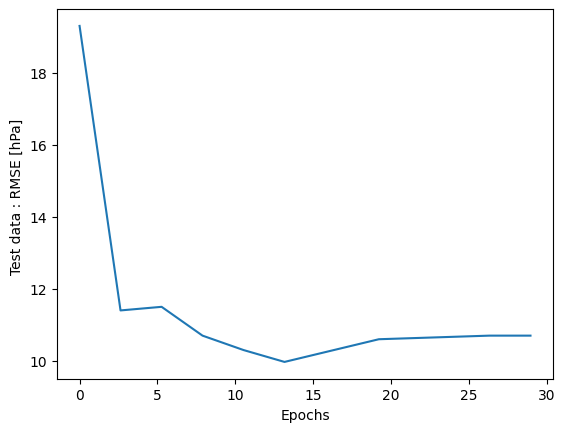

In [17]:
import matplotlib.pyplot as plt
import numpy as np
# Zip the two lists together and sort by x
xy_sorted = sorted(zip(x, y), key=lambda pair: pair[0])

# Unzip the sorted pairs back into x_sorted and y_sorted
x_sorted, y_sorted = zip(*xy_sorted)

# Plot
plt.plot(np.array(x_sorted)/3/380, y_sorted)
plt.xlabel('Epochs')
plt.ylabel('Test data : RMSE [hPa] ')
plt.show()


In [14]:
57/0.15


380.0